In [1]:
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 100
rcParams["savefig.dpi"] = 150

import numpy as np
import corner
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm
from maelstrom import Maelstrom

red = '#e41a1c'
blue = '#377eb8'
green = '#4daf4a'
purple = '#984ea3'
orange = '#ff7f00'

In [2]:
import matplotlib
matplotlib.rcParams["font.size"] = 9.

def mnras_size(fig_width_pt, square=False):
    #Paper width = 597.5  for 2 columns or 504?
    #Col width = 240.0    #for single column
    inches_per_pt = 1.0/72.00              # Convert pt to inches
    golden_mean = (np.sqrt(5)-1.0)/2.0         # Most aesthetic ratio
    fig_width = fig_width_pt*inches_per_pt  # Figure width in inches
    if square:
        fig_height = fig_width
    else:
        fig_height = fig_width*golden_mean
    fig_size = [fig_width,fig_height]
    return fig_size

In [3]:
from astropy.stats import LombScargle
from astropy.convolution import convolve, Box1DKernel
import math

def amp_spectrum(t, y, fmin=None, fmax=None, nyq_mult=1., oversample_factor=5.):
    tmax = t.max()
    tmin = t.min()
    df = 1.0 / (tmax - tmin)
    
    if fmin is None:
        fmin = df
    if fmax is None:
        fmax = (0.5 / np.median(np.diff(t)))*nyq_mult

    freq = np.arange(fmin, fmax, df / oversample_factor)
    model = LombScargle(t, y)
    sc = model.power(freq, method="fast", normalization="psd")

    fct = np.sqrt(4./len(t))
    amp = np.sqrt(sc) * fct
    
    return freq, amp


def smooth(freq, power, method='boxkernel', filter_width=0.1):

    if method == 'boxkernel':
        if filter_width <= 0.:
            raise ValueError("the `filter_width` parameter must be "
                             "larger than 0 for the 'boxkernel' method.")
        fs = np.mean(np.diff(freq))
        box_kernel = Box1DKernel(math.ceil((filter_width/fs)))
        smooth_power = convolve(power, box_kernel)
        return smooth_power

    if method == 'logmedian':
        count = np.zeros(len(freq), dtype=int)
        bkg = np.zeros_like(freq)
        x0 = np.log10(freq[0])
        while x0 < np.log10(freq[-1]):
            m = np.abs(np.log10(freq) - x0) < filter_width
            if len(bkg[m] > 0):
                bkg[m] += np.nanmedian(power)
                count[m] += 1
            x0 += 0.5 * filter_width
        bkg /= count
        smooth_power = bkg
        return smooth_power

In [4]:
import numpy as np
from lightkurve import search_lightcurvefile

def get_lightcurve(target, **kwargs):
    lc_collection = search_lightcurvefile(target, **kwargs).download_all()

    lc = lc_collection[0].PDCSAP_FLUX.normalize()
    for l in lc_collection[1:]:
        lc = lc.append(l.PDCSAP_FLUX.normalize())

    lc = lc.remove_nans()
    magnitude = -2.5 * np.log10(lc.flux)
    magnitude = magnitude - np.average(magnitude)
    return lc.time, magnitude

In [5]:
t, y = get_lightcurve('KIC 6780873', cadence='long')

(-500, 500)

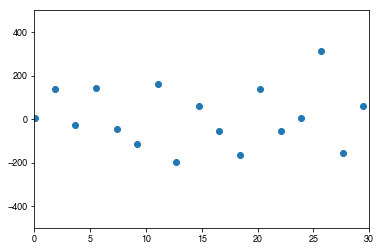

In [6]:
from maelstrom import Maelstrom

ms = Maelstrom(t,y, max_peaks=2, fmin=10)
td_time, td_td = ms.get_time_delay(segment_size=9.15/5)
plt.scatter(td_time, td_td[0])
plt.xlim(0,30)
plt.ylim(-500,500)

In [7]:
ms.setup_orbit_model(period=9.131, eccen=0.03)
opt = ms.optimize()

In [8]:
opt

{'logperiod': array(2.21453558),
 't0': array(-1.31826926),
 'varpi_angle__': array([0.75750509, 4.40751744]),
 'eccen_interval__': array(-0.36686436),
 'logs': array(-5.52838829),
 'lighttime': array([-17.36213008, -17.77029613]),
 'mean_flux': array(2.17651819e-07),
 'W_hat_cos': array([ 0.00138751, -0.00068784]),
 'W_hat_sin': array([ 0.00126476, -0.00079705]),
 'period': array(9.15715535),
 'varpi': array(0.17020378),
 'eccen': array(0.40930073),
 'tref': array(-2.27255886)}

(-500, 500)

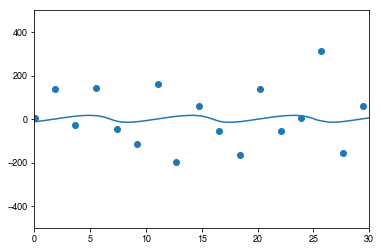

In [9]:
plt.scatter(td_time, td_td[0])
plt.plot(ms.time,ms.evaluate(ms.tau)[:,0] * 86400)
plt.xlim(0,30)
plt.ylim(-500,500)

In [50]:
ms.evaluate(ms.tau, opt)[:,0]

array([0.0003118 , 0.00031301, 0.0003142 , ..., 0.0002331 , 0.00023019,
       0.00022724])

In [17]:
trace = ms.sample(tune=1000, draws=1000)

Sampling 2 chains:  23%|██▎       | 24/104 [01:34<05:14,  3.93s/draws]


ValueError: Not enough samples to build a trace.

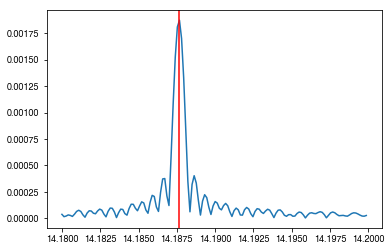

In [26]:
plt.plot(*amp_spectrum(t,y,fmin=14.18,fmax=14.2))
plt.axvline(ms.freq[0], c='r')

In [27]:
from astroquery.mast import Catalogs
tic = '124381332'
Catalogs.query_object(tic, catalog="tic", radius=0.001)

ID,ra,dec,pmRA,pmDEC,Tmag,objType,typeSrc,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,POSflag,e_pmRA,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,TWOMflag,prox,w1mag,e_w1mag,w2mag,e_w2mag,w3mag,e_w3mag,w4mag,e_w4mag,GAIAmag,e_GAIAmag,e_Tmag,TESSflag,SPFlag,Teff,e_Teff,logg,e_logg,MH,e_MH,rad,e_rad,mass,e_mass,rho,e_rho,lumclass,lum,e_lum,d,e_d,ebv,e_ebv,numcont,contratio,disposition,duplicate_id,priority,dstArcSec
str9,float64,float64,float64,float64,float64,str4,str5,str8,str1,str12,str10,str16,str1,str19,str19,str8,str1,str6,float64,float64,str4,float64,float64,str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,int64,float64,str1,str1,float64,float64
124381332,93.017426,-20.910841,-4.02737,7.49745,9.623,STAR,2mass,20180610,--,5945-00497-1,346-011296,06120418-2054390,--,J061204.17-205438.9,2941067435341519488,10319692,--,tmgaia,0.498555,0.594197,tgas,3.5595,0.321217,tgas,227.828681,-17.749489,93.940286,-44.308869,9.872,0.042,9.692,0.003,--,--,--,--,--,--,--,--,--,--,9.464,0.026,9.401,0.024,9.346,0.021,AAA-222-111-000-0-0,12.0,9.311,0.023,9.323,0.02,9.037,0.029,5.984,0.044,9.7174,0.000345996,0.019,gaiaj,tplx,8111.0,221.0,4.39921,0.424018,--,--,1.46977,0.2759,1.97369,0.388978,0.621628,0.35007,DWARF,8.4234705,3.162448,280.9382,--,0.0931308,--,71,0.0222926773,--,--,0.00173743709,0.0


In [28]:
Catalogs.query_criteria?